# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils

We're using TF 2.1.0


Using TensorFlow backend.


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [3]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]

 A closeup of a sample patch:


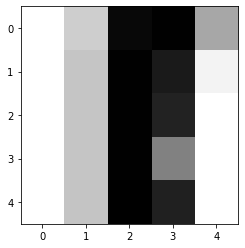

And the whole sample:


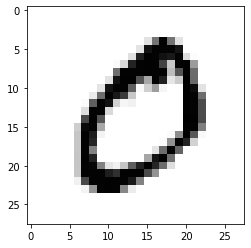

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [7]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("\n A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

#### Linear model

We want to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

We will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0,\ldots,9$$
where $w_k \in \mathbb{R}^{784}, b^k\in \mathbb{R}^{10}$.
Then we transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0,\ldots,9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with to simplify our linear model implementation
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [31]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [32]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [33]:
# Initialize model parameters: W and b
w = tf.random.uniform(
    shape=(784, 10), minval=0, maxval=None, dtype=tf.float32, seed=12, name=None)
b = tf.random.uniform(
    shape=[10], minval=0, maxval=None, dtype=tf.float32, seed=10, name=None)
 
W = tf.Variable(w, trainable=True) 
b = tf.Variable(b, trainable=True)

In [34]:
def logits(input_X, W, b):
    return input_X @ W + b # Resulting shape is [input_X.shape[0], 10]

In [35]:
def predictions(logits): 
    probas = tf.nn.softmax(logits) 
    classes = tf.argmax(probas, axis=1) 
    return classes

In [36]:
def loss(y_true, preds):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true, preds))

In [39]:
step = tf.keras.optimizers.Adagrad(learning_rate=0.26) 
BATCH_SIZE = 512
EPOCHS = 100

simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):
        
        loss_ = lambda : loss(y_train_oh[batch_start:batch_start+BATCH_SIZE],
                            X_train_flat[batch_start:batch_start+BATCH_SIZE]@W + b)
        step.minimize(loss_, var_list=[W, b])
        
        batch_loss = loss(y_train_oh[batch_start:batch_start+BATCH_SIZE],
                          X_train_flat[batch_start:batch_start+BATCH_SIZE]@W+b)
        
        batch_losses.append(tf.keras.backend.eval(batch_loss))

    train_loss = np.mean(batch_losses)

    val_loss = loss(y_val_oh, X_val_flat@W+b) 
    train_accuracy = accuracy_score(y_train, predictions(X_train_flat@W+b))
    valid_accuracy = accuracy_score(y_val, predictions(X_val_flat@W+b))  
    print(valid_accuracy)
    simpleTrainingCurves.add(tf.keras.backend.eval(train_loss),
                             tf.keras.backend.eval(val_loss), 
                             tf.keras.backend.eval(train_accuracy), 
                             tf.keras.backend.eval(valid_accuracy))

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxPb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgX4X8Nay3hfxV470a58RHRfGV/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhEy3qw/aTbReYCFGPUfjR/wTotfj1%2Bzb4n%2BHHxD%2BOfjW78d%2BMPhfH4Z17xS3jbWho818tpDE2oJoS3y2FuzzQLK3kRRSEPIBIrSM5AOkg/4KUfsZf8K58V/FbWPite6Jo3giysr7xQ/ifwdq%2Bk3NlZXkxhtb37LeWsVxJaSyK6pcxxtC3luQ%2BEYjj/AI3f8FZP2d/hn8ENU%2BMfgPRfFXiqbQfiD4X8L674Y/4QXXbHU7A6zqVrax3T2cmnNdeV5Fw88DeT5d48aW8MhknjB8r1T/gmJ8ZPHfwq8faR4i8DeG9G8Y%2BI9D0fR7DxDqv7RfjPxut3aWusW%2BoTRyf27AfsEZ8likUSzHe%2BGkxknv8A9qH9gz40/GD4g/F/4g%2BBfEPheOTxfB8LbzwlZ6tfXMSvf%2BE/EdzrUsN40dvJ5ENwGt4VljEzrl2MfyKrgHqFh/wUE/Zb1H4m2XwZh8T%2BJo/Fd5oun6xLoF38N9egudO0%2B9adILu/SSyU6dDut5VeS68pYiFEhQum6j4a/wCCmH7FPi3wZ4s%2BIWkfGC4TR/Bfgi68Zaxe6h4S1W0Fx4et0Z5tWsVntUbVLNVQ4nsxPGxZArEugbB0P9kP4ofEP4mfG74g/G9fD2gxfGj4O%2BHfCF1Y%2BE9duNRl0u4tE11Ltlnns7XzYwNViMT7FZikm6OPA3fN37Y37Kn7UOj/ALDHxS%2BJv7TF34AtIfhD%2BxT8QfBHhePwFqF5cNrzXukWxn1G6W5toBYqE0i3CWcbXAVppCZ22oKAPrPw9/wUl/Yy8TaHrHiPT/i1dQWehppU1/JqnhLVbJmtNSu1s7HUIUuLVGubCWdgovoQ9qoDO0qorMPT9E%2BLvw88R/FLX/gvofiH7T4k8LaXp%2Boa/YR2k22zgvmuBa7pinlF3%2ByzHy1cyKoRmVVkjLfJOofsz%2BIPFegeKfjb/wAFIvF/wz8J%2BBbf9nu5%2BHUlx4f8QTLay6beyQyXmq3k17BbpYOTBbCG2QzCAmT/AEiQsuOw/wCCPngP4u2f7I9r8f8A9pDUDf8AxJ%2BL15H4n8V6g9nJbtJCLSCy01fKl%2BeH/iX2lpI0TYKSzTZAYtkA%2BqqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8R0j/AIKMfse6ld69Z6n8Urzw83hzw5c%2BINQk8a%2BEdV0GObSbd0jnv7WTUrWBb63R5IlaW2MqAyxjOXXPtN7FczWcsNndCCZ4mWKYx7/LYjhtp64POO9fmJq//BHL9uX4v6t4X1z43fHHQ31vw14P1Cz1DxRqHxW8TeJx4h1v7ZpV9a6idLvoobLSbaS50xfPsLIBRHJtWWQKgUA%2B2X/b/wD2YbX4aN8WNY8QeKtK0ttcg0axs9c%2BGWv2GqanfzIZIYLLTbixS9v2kQM6/Z4ZAyo7AkIxHReA/wBqz4H/ABH1%2By8J%2BHPEOqQ6vf8AhSfxJDpGteFdS0y7TTYbv7JLLLDeW8UkDrP8hhkVZe%2BzbzXk3xO%2BDn7bvxib4e/G3XPBvwq0P4h/Cjx1NrHh/wAM2vjjUr/Rdcs7jSbvTLmO4vn0qGaxmKXskkbpa3AjMQU%2BYJGxV%2BJPwG/bg1/4y%2BHf2mvA%2BjfCu08WX3ww1XwX4x0LUvFepSWGkLcX8N1a39lcJpwk1AxCN1kt5YrQSlxiWLHIB3Gk/wDBRv8AZA8R694F8LeFfiNqus6n8SfBuleLfBunaJ4H1m9nvND1F9lrqMiQWjNa2%2B7HmSTiNbcMpm8oMCdj4a/tufs3fFf4jXPwn8M%2BL9Ws9ft9LudThsvE/gzVtEW/sbeRI57uyl1G1gjv4I3liDy2zSIvmISQGUnyj9hT9hL4sfsw6/8ADjWfHniDw1dnwd%2Byl4R%2BGN%2B%2BkXM8rNq2lvM1zNF5kEe61bemxmKu235o0wK8a%2BGn/BKv9sbxP8UfC/ib9qb4w2eqRaf4A8V%2BF/GniaD4v%2BJNavPEUur2KW39p2umX0Men6EcqWNpaKUXKgTOI1WgD6l8J/8ABRf9kfxrosfirQfHeuf2Hcarpen6f4lvfh/rdrpWoy6lex2VlJaX09mlteQS3M0UYuIJHhBlQs4VgT6X4W%2BLvw88a/EDxT8LvC/iH7XrnguSzj8T2iWkwWxkuoPtEEZlZBG7tCVkKIzMiyRlgokTd8w%2BOPAnxF8K/wDBPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2GadI0trXUntLqzgTTZlmFvJDBHcXTGcoiOTtDdr/AMEr/h98WPDf7ImlfFX9oqwS3%2BJ3xYvpfHXxEhW3aL7Pf36xmG02N8yfZbGOys9pyQLXBoA%2BjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAC

# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train_flat, y_train_oh, batch_size=512, epochs=50,
         validation_data=(X_val_flat, y_val))


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 1s 16us/step - loss: 1.7603 - accuracy: 0.7629 - val_loss: 105.3230 - val_accuracy: 0.1002
Epoch 2/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.5728 - accuracy: 0.9111 - val_loss: 105.4666 - val_accuracy: 0.1043
Epoch 3/50
50000/50000 [==============================] - 1s 14us/step - loss: 1.5490 - accuracy: 0.9275 - val_loss: 105.5418 - val_accuracy: 0.0990
Epoch 4/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.5360 - accuracy: 0.9372 - val_loss: 105.5717 - val_accuracy: 0.0991
Epoch 5/50
50000/50000 [==============================] - 1s 16us/step - loss: 1.5270 - accuracy: 0.9441 - val_loss: 105.5926 - val_accuracy: 0.0997
Epoch 6/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.5206 - accuracy: 0.9498 - val_loss: 105.6163 - val_accuracy: 0.1011
Epoch 7/50
50000/50000 [==============================] 